In [1]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import pywt

In [2]:
#spo2 = wfdb.rdrecord('apnea-ecg-database/a01r', channel_names = ["SpO2"], sampto=600001)
#apnea_ann = wfdb.rdann('apnea-ecg-database/a01r', extension="apn", sampto=600001)
data_files = ["a01", "a02", "a03", "a04", "b01", "c01", "c02", "c03"]

#data_files = ["a04"]

#wfdb.plot_items(signal=spo2.p_signal,ann_samp= [apnea_ann.sample],time_units = 'samples')

In [3]:
for file in data_files:
    spo2 = wfdb.rdrecord(f'apnea-ecg-database/apnea_samples/{file}r', channel_names = ["SpO2"])
    apnea_ann = wfdb.rdann(f'apnea-ecg-database/apnea_samples/{file}r', extension="apn")
    #wfdb.plot_items(signal=spo2.p_signal,ann_samp= [apnea_ann.sample],time_units = 'samples')
    spo2_data = np.copy(spo2.p_signal)
    apnea_ann_data = np.array(apnea_ann.symbol)
    #np.savetxt("afour.csv", spo2_data, delimiter=",")
    spo2_data.resize(apnea_ann_data.shape[0], 60, 100)
    spo2_data.reshape(apnea_ann_data.shape[0], 60, 100)
    spo2_median_data = np.median(spo2_data, axis=2)
    print(spo2_median_data.shape)
    apnea_df = pd.DataFrame(data = spo2_median_data, index=np.arange(1, apnea_ann_data.shape[0] + 1, 1), columns=np.arange(1, 61, 1))
    apnea_df["apnea"] = apnea_ann_data == 'A'
    #fapnea_df = apnea_df[~(apnea_df < 40).all(axis=1)]
    apnea_df.to_csv(f"processed_data/{file}.csv", index=False)
raw = apnea_df.drop('apnea', axis=1).to_numpy()
raw = raw.reshape(raw.shape[0] * raw.shape[1], 1)
plt.plot(np.arange(len(raw)), raw)
#apnea_df.min(axis=1)

(489, 60)
(528, 60)
(519, 60)
(492, 60)


FileNotFoundError: [Errno 2] No such file or directory: '/home/peter/projects/math564/apnea/apnea-ecg-database/apnea_samples/a05r.hea'

In [ ]:
df = pd.read_csv("processed_data/a04.csv")
df

In [8]:
folder = "processed_data/"

dfs = []
count = 1
for name in os.listdir(folder):
    if not ".csv" in name:
        continue
    df = pd.read_csv(folder + name)
    df = df[(df.drop("apnea", axis=1) >= 50).all(axis=1)]
    dfs.append(df)
    print(f"processed {count}!")
    count = count + 1
all_apnea = pd.concat(dfs, ignore_index=True)
all_apnea.to_csv("processed_data/combined_apnea.csv", index=False)

processed 1!
processed 2!
processed 3!
processed 4!
processed 5!
processed 6!
processed 7!
processed 8!


In [4]:
ap = pd.read_csv("processed_data/combined_apnea.csv")
def process_row(row):
    # Split the row into chunks of 10 for SpO2 data, excluding the last column (apnea indicator)
    spo2_chunks = [row[i:i+100] for i in range(0, 6000, 100)]
    # Calculate the median of each chunk and append the apnea indicator at the end
    processed_row = [chunk.median() for chunk in spo2_chunks] + [row['apnea']]
    if int(row.name) % 100 == 0:
        print(f"processed row {row.name}")
    return processed_row

# Apply the function to each row
processed_data = ap.apply(process_row, axis=1, result_type='expand')

# Rename the columns accordingly
processed_data.columns = [str(i) for i in range(1, 61)] + ['apnea']

# Display the first few rows of the processed dataframe
processed_data.head()

processed row 0
processed row 100
processed row 200
processed row 300
processed row 400
processed row 500
processed row 600
processed row 700
processed row 800
processed row 900
processed row 1000
processed row 1100
processed row 1200
processed row 1300
processed row 1400
processed row 1500
processed row 1600
processed row 1700
processed row 1800
processed row 1900
processed row 2000
processed row 2100
processed row 2200
processed row 2300
processed row 2400
processed row 2500
processed row 2600
processed row 2700
processed row 2800
processed row 2900
processed row 3000
processed row 3100
processed row 3200
processed row 3300
processed row 3400
processed row 3500
processed row 3600
processed row 3700


,1,2,3,4,5,6,7,8,9,10,...,52,53,54,55,56,57,58,59,60,apnea
0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,98.0,98.0,98.0,...,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,False
1,97.0,97.0,97.0,97.0,97.0,97.0,97.0,96.0,96.0,96.0,...,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,False
2,96.0,96.0,96.0,96.0,96.0,96.0,94.0,94.0,94.0,94.0,...,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,False
3,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,...,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,False
4,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,...,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,False


In [5]:
processed_data.to_csv("processed_data/combined_apnea_down.csv", index=False)

1101

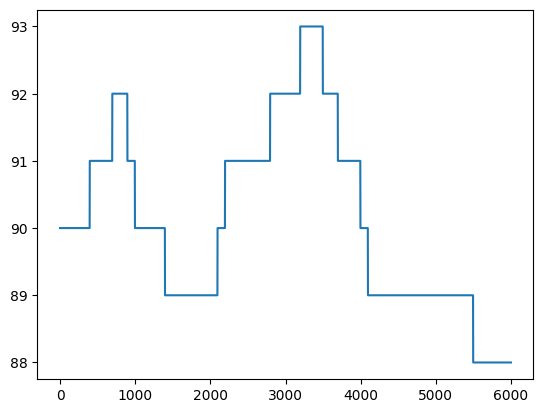

In [64]:
x = pd.read_csv("processed_data/combined_apnea.csv")
x_ap = x[x.apnea == True]
x_nap = x[x.apnea == False]


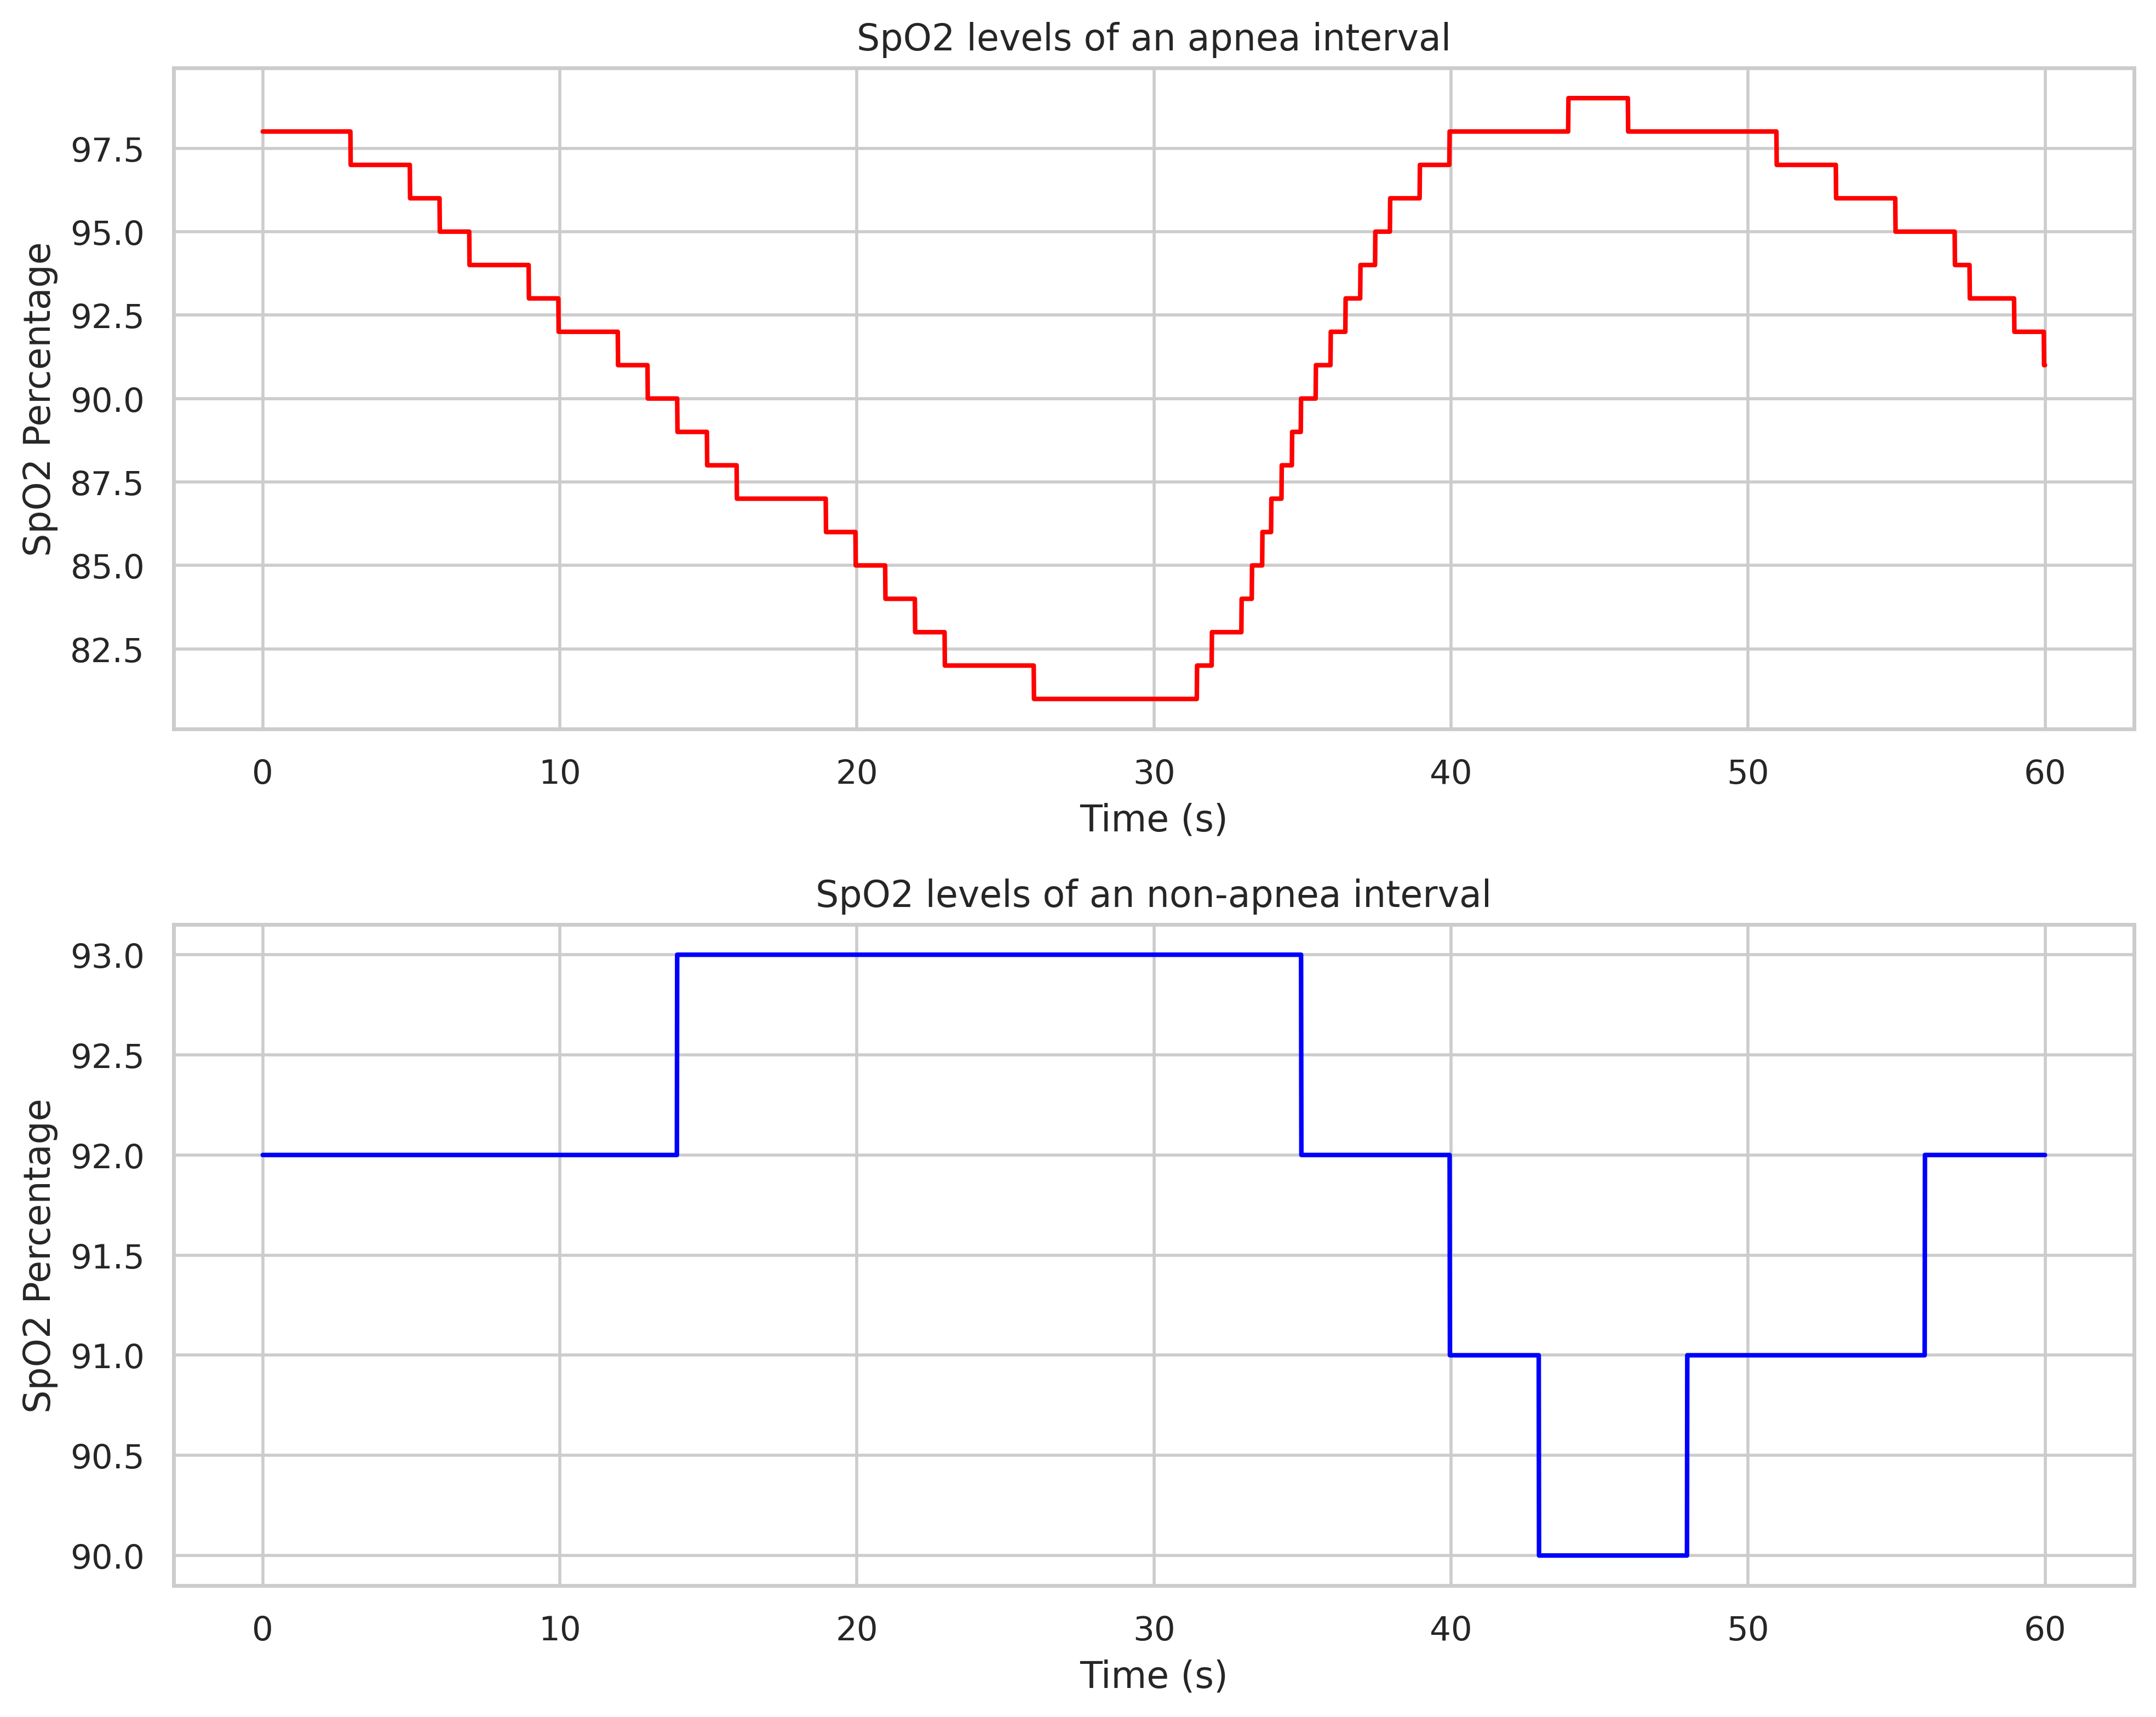

In [108]:
import random
import seaborn as sns
#1122 ap
#1270 nap
num = 1123

sns.set(style="whitegrid")  # Sets the style of the plot

fig, axes = plt.subplots(2, 1, figsize=(10, 8), dpi=400)  # Creates 2 subplots

sns.lineplot(x=np.arange(0, len(x_ap.iloc[num]) - 1), y=x_ap.iloc[num][:-1], ax=axes[0], color='red')

axes[0].set_title('SpO2 levels of an apnea interval')
axes[0].set_ylabel('SpO2 Percentage')
axes[0].set_xlabel('Time (s)')
# Set new x-axis labels
scale_factor = 100  # Scale down by a factor of 100
ticks = np.linspace(0, len(x_ap.iloc[num]) - 1, num=7)  # Creates 7 evenly spaced ticks
new_labels = [f"{int(tick / scale_factor)}" for tick in ticks]  # Scale labels down
axes[0].set_xticks(ticks)  # Set custom ticks
axes[0].set_xticklabels(new_labels)  # Set custom labels
num = 1112

sns.lineplot(x=np.arange(0, len(x_nap.iloc[num]) - 1), y=x_nap.iloc[num][:-1], ax=axes[1], color='blue')

axes[1].set_title('SpO2 levels of an non-apnea interval')
axes[1].set_ylabel('SpO2 Percentage')
axes[1].set_xlabel('Time (s)')

axes[1].set_xticks(ticks)  # Use the same ticks for uniformity across subplots
axes[1].set_xticklabels(new_labels)  # Use the same labels

plt.tight_layout()  # Adjusts plot parameters to give the subplot(s) more room
#plt.show()

plt.savefig('spo2_compare.png')  # Saves as PNG file